In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import matplotlib.patches as patches

import core
import os

import seaborn as sns
sns.set_theme(context="talk", style="white")
unsafe_color = sns.color_palette("pastel")[3]
safe_color = sns.color_palette("pastel")[2]

In [2]:
net = core.CLF_QP_Net(n_input=4, n_hidden=64, n_controls=1)
net.load_state_dict(torch.load('./save/model.pth'))
net.eval()

CLF_QP_Net(
  (Vfc_layer_1): Linear(in_features=4, out_features=64, bias=True)
  (Vfc_layer_2): Linear(in_features=64, out_features=64, bias=True)
  (Vfc_layer_3): Linear(in_features=64, out_features=16, bias=True)
  (Ufc_layer_1): Linear(in_features=4, out_features=64, bias=True)
  (Ufc_layer_2): Linear(in_features=64, out_features=64, bias=True)
  (Ufc_layer_3): Linear(in_features=64, out_features=1, bias=True)
)

100%|██████████| 30/30 [00:01<00:00, 29.98it/s]


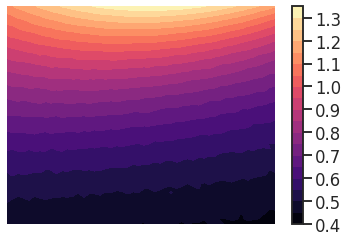

In [15]:
res = 50 # resultion
num_iter = 30

x, y = np.meshgrid(np.linspace(-0.5, 0.5, res), np.linspace(0.2, 1.0, res))
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

z = np.zeros(shape=(res, res))
vdot = np.zeros(shape=(res, res))

num_iter = 30
for j in tqdm(range(num_iter)):
    v = np.random.uniform(-0.1, 0.1, size=x.shape)
    omega = np.random.uniform(-0.1, 0.1, size=y.shape)
    
    theta = np.arccos(y) * np.random.choice([-1, 1])
    p = x - np.sin(theta)

    s = np.concatenate([p, theta, v, omega], axis=1).astype(np.float32)
    s = torch.from_numpy(s)
    _, V, Vdot = net(s)
    z = z + np.reshape(V.detach().numpy(), (res, res))
    vdot = vdot + np.reshape(Vdot.detach().numpy(), (res, res))

z = z / num_iter
vdot = vdot / num_iter

x = np.reshape(x, (res, res))
y = np.reshape(y, (res, res))

contours = plt.contourf(x, y, z, cmap="magma", levels=20)
plt.colorbar(contours, orientation="vertical")
plt.axis('off')

plt.savefig('contour.png')
plt.show()

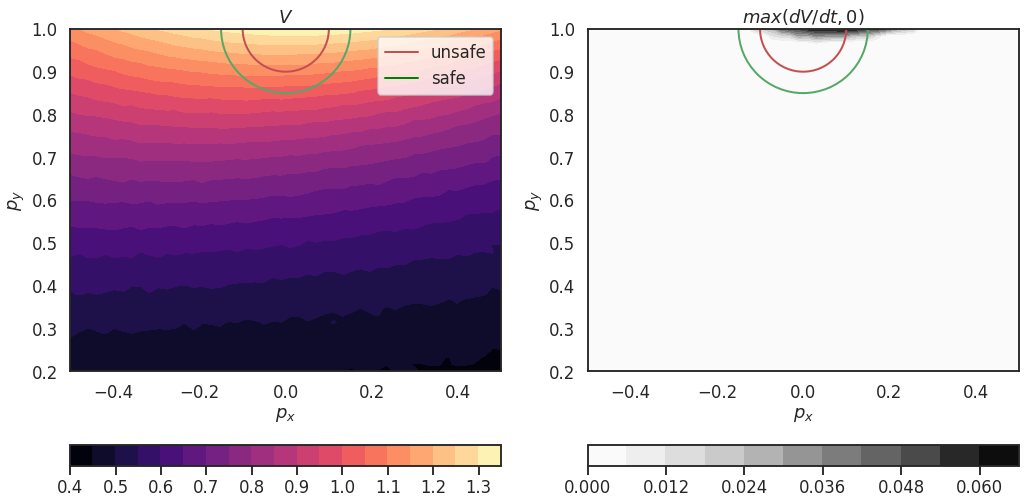

In [21]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(17, 9)
contours = axs[0].contourf(x, y, z, cmap="magma", levels=20)
plt.colorbar(contours, ax=axs[0], orientation="horizontal")

unsafe_sector = patches.Wedge((0, 1), 0.1, -180, 0, linewidth=2,
                             edgecolor='r', facecolor=unsafe_color, fill=False)
safe_sector = patches.Wedge((0, 1), 0.15, -180, 0, linewidth=2,
                             edgecolor='g', facecolor=safe_color, fill=False)

axs[0].add_patch(safe_sector)
axs[0].add_patch(unsafe_sector)

axs[0].plot([0], [1], color='r', linewidth=2, label='unsafe')
axs[0].plot([0], [1], color='green', linewidth=2, label='safe')

axs[0].set_xlabel('$p_x$')
axs[0].set_ylabel('$p_y$')
axs[0].set_title('$V$')
axs[0].legend()

contours = axs[1].contourf(x, y, np.maximum(0, vdot + 0.05 * z), cmap="Greys", levels=10)
plt.colorbar(contours, ax=axs[1], orientation="horizontal")

unsafe_sector = patches.Wedge((0, 1), 0.1, -180, 0, linewidth=2,
                             edgecolor='r', facecolor=unsafe_color, fill=False)
safe_sector = patches.Wedge((0, 1), 0.15, -180, 0, linewidth=2,
                             edgecolor='g', facecolor=safe_color, fill=False)

axs[1].add_patch(safe_sector)
axs[1].add_patch(unsafe_sector)

axs[1].set_xlabel('$p_x$')
axs[1].set_ylabel('$p_y$')
axs[1].set_title('$max(dV/dt, 0)$')

plt.savefig('contour.png')
plt.show()